In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from tqdm import tqdm

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset, Subset


In [ ]:
#Data Augmentation
#Horizontal flip, rotation , Crop
train_dir = "/content/drive/My Drive/Colab Notebooks/APS360/Project/Dataset/pix2pix_np_splitdataset/train/"
import torchvision.transforms.functional as F
import random # Import the random module


class Augmentation:
    def __call__(self,sat,maps):

        if torch.rand(1) < 0.5:
            sat= F.hflip(sat)
            maps = F.hflip(maps)

        rotation_angle = [0,90,180]
        if rotation_angle:
           angle = random.choice(rotation_angle)
        if angle != 0:
            sat = F.rotate(sat, angle)
            maps = F.rotate(maps, angle)

        sat = F.resize(sat, 286)
        maps = F.resize(maps, 286)

        i, j, h, w = transforms.RandomCrop.get_params(sat, output_size=(256, 256))
        sat = F.crop(sat, i, j, h, w)
        maps = F.crop(maps, i, j, h, w)

        return sat,maps

In [ ]:
class Pix2PixDataset(Dataset):
    def __init__(self, root_dir, augment= True):
      self.augment = augment
      self.root_dir = root_dir
      self.image_files = os.listdir(root_dir)
      print(f"Found {len(self.image_files)} files in {root_dir}") # Added print
      self.data = []
      for filename in self.image_files:
          npz_path = os.path.join(self.root_dir, filename)
          try: # Added try-except block
              with np.load(npz_path) as data:
                  self.data.append((data['input'], data['target']))
          except Exception as e: # Added exception handling
              print(f"Error loading {npz_path}: {e}") # Added print for errors
      print(f"Loaded {len(self.data)} data samples.") # Added print


    def __len__(self):
      return len(self.data) # Changed from self.image_files to self.data

    def __getitem__(self, idx):
        input_img, target_img = self.data[idx]
        #normalized te image
        input_img = torch.from_numpy(input_img).float()
        target_img = torch.from_numpy(target_img).float()

        if self.augment:
            augment = Augmentation()
            input_img, target_img = augment(input_img, target_img)

        return input_img, target_img

In [ ]:
train_dataset = Pix2PixDataset("/content/drive/My Drive/Colab Notebooks/APS360/Project/Dataset/pix2pix_np_splitdataset/train/", augment= True )
val_dataset = Pix2PixDataset("/content/drive/My Drive/Colab Notebooks/APS360/Project/Dataset/pix2pix_np_splitdataset/val/", augment=False )
test_dataset = Pix2PixDataset("/content/drive/My Drive/Colab Notebooks/APS360/Project/Dataset/pix2pix_np_splitdataset/test/", augment=False)

train_loader = DataLoader(train_dataset, batch_size=64)
val_loader = DataLoader(val_dataset, batch_size=64)


Found 1755 files in /content/drive/My Drive/Colab Notebooks/APS360/Project/Dataset/pix2pix_np_splitdataset/train/
Loaded 1755 data samples.
Found 219 files in /content/drive/My Drive/Colab Notebooks/APS360/Project/Dataset/pix2pix_np_splitdataset/val/
Loaded 219 data samples.
Found 220 files in /content/drive/My Drive/Colab Notebooks/APS360/Project/Dataset/pix2pix_np_splitdataset/test/
Loaded 220 data samples.


In [ ]:
test_loader = DataLoader(test_dataset, batch_size=64)

Input shape: (3, 256, 256) Min: -1.0 Max: 1.0
Target shape: (3, 256, 256) Min: 0.26274514 Max: 1.0


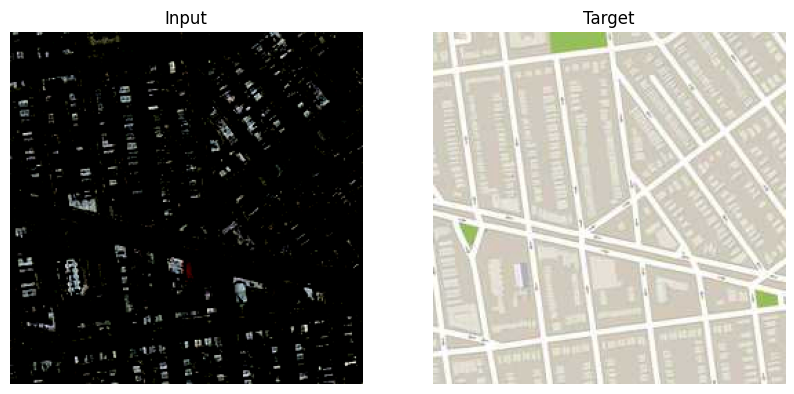

In [ ]:
npz_path = "/content/drive/My Drive/Colab Notebooks/APS360/Project/Dataset/pix2pix_np_splitdataset/train/1.npz"


data = np.load(npz_path)
input_img = data['input']
target_img = data['target']


print("Input shape:", input_img.shape, "Min:", input_img.min(), "Max:", input_img.max())
print("Target shape:", target_img.shape, "Min:", target_img.min(), "Max:", target_img.max())


if input_img.shape[0] == 3:
    input_img = np.transpose(input_img, (1, 2, 0))
if target_img.shape[0] == 3:
    target_img = np.transpose(target_img, (1, 2, 0))

if input_img.max() > 1:
    input_img = input_img / 255.0
if target_img.max() > 1:
    target_img = target_img / 255.0


fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.clip(input_img, 0, 1))
axs[0].set_title("Input")
axs[0].axis('off')
axs[1].imshow(np.clip(target_img, 0, 1))
axs[1].set_title("Target")
axs[1].axis('off')
plt.show()

In [ ]:
class EncoderBlock(nn.Module):
  def __init__(self, Input_Channels, Output_Channels, Batchnorm = False):
    super(EncoderBlock, self).__init__()
    self.batchnorm = Batchnorm
    self.conv = nn.Conv2d(Input_Channels, Output_Channels, 4,2, 1)

    if self.batchnorm:
      self.bn = nn.BatchNorm2d(Output_Channels)


    self.Leakyrelu = nn.LeakyReLU(0.2, inplace = True)

  def forward(self, x):
    x = self.conv(x)
    if self.batchnorm:
      x = self.bn(x)
    x = self.Leakyrelu(x)
    return x

In [ ]:
class DecoderBlock(nn.Module):
  def __init__(self, Input_Channels, Output_Channels, Dropout = True):
    super(DecoderBlock, self).__init__()
    self.conv_trans= nn.ConvTranspose2d(Input_Channels, Output_Channels, 4, 2, 1, bias=False)
    self.norm = nn.InstanceNorm2d(Output_Channels)
    self.relu = nn.ReLU(inplace=True) #again for the upscaling portion Relu is commonly used


    self.use_dropout = Dropout
    if self.use_dropout:
      self.dropout = nn.Dropout(0.5)

  def forward(self, x, skip_input):
    x = self.conv_trans(x)
    x = self.norm(x)
    if self.use_dropout:
      x = self.dropout(x)
    x = self.relu(x)
    x = torch.cat((x, skip_input), 1)
    return x

In [ ]:
class Generator(nn.Module):
  def __init__(self, in_channels=3, out_channels=3):
    super(Generator,self).__init__()

    self.dn1 = EncoderBlock(in_channels, 64, Batchnorm = False)
    self.dn2 = EncoderBlock(64, 128)
    self.dn3 = EncoderBlock(128, 256)
    self.dn4 = EncoderBlock(256,512)
    self.dn5 = EncoderBlock(512,512)
    self.dn6 = EncoderBlock(512,512)
    self.dn7 = EncoderBlock(512,512)
    self.dn8 = EncoderBlock(512,512)

    self.up1 = DecoderBlock(512, 512)
    self.up2 = DecoderBlock(1024, 512)
    self.up3 = DecoderBlock(1024, 512)
    self.up4 = DecoderBlock(1024, 512, Dropout=False)
    self.up5 = DecoderBlock(1024, 256, Dropout=False)
    self.up6 = DecoderBlock(512, 128, Dropout=False)
    self.up7 = DecoderBlock(256, 64, Dropout=False)

    self.final = nn.Sequential(
        nn.Upsample(scale_factor = 2),
        nn.ZeroPad2d((1,0,1,0)),
        nn.Conv2d(128, out_channels, 4, padding=1), #number of output channels
        nn.Tanh() #final activation changes in all I guess we can tune this as well idk?

    )

  def forward(self, x):
    d1 = self.dn1(x)
    d2 = self.dn2(d1)
    d3 = self.dn3(d2)
    d4 = self.dn4(d3)
    d5 = self.dn5(d4)
    d6 = self.dn6(d5)
    d7 = self.dn7(d6)
    d8 = self.dn8(d7)
    u1 = self.up1(d8, d7)
    u2 = self.up2(u1, d6)
    u3 = self. up3 (u2, d5)
    u4 = self. up4(u3, d4)
    u5 = self. up5(u4, d3)
    u6 = self. up6(u5, d2)
    u7 = self.up7(u6, d1)
    u8 = self. final(u7)
    return u8

In [ ]:
model = Generator()
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [ ]:
import torch

# Choose device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Move model to device
model.to(device)

def train(model, train_loader, val_loader, epochs=20):
    model = model.to(device)
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

        train_loss = running_train_loss / len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                running_val_loss += loss.item()

        val_loss = running_val_loss / len(val_loader)
        val_losses.append(val_loss)

        print(f"[{epoch+1}/{epochs}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    return train_losses, val_losses


Using device: cuda


In [ ]:
import matplotlib.pyplot as plt

def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('L1 Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


Epoch 1: 100%|██████████| 28/28 [00:46<00:00,  1.67s/it]


[1/10] Train Loss: 0.0983 | Val Loss: 0.1009


Epoch 2: 100%|██████████| 28/28 [00:45<00:00,  1.63s/it]


[2/10] Train Loss: 0.0943 | Val Loss: 0.0974


Epoch 3: 100%|██████████| 28/28 [00:45<00:00,  1.64s/it]


[3/10] Train Loss: 0.0926 | Val Loss: 0.0951


Epoch 4: 100%|██████████| 28/28 [00:45<00:00,  1.61s/it]


[4/10] Train Loss: 0.0905 | Val Loss: 0.0964


Epoch 5: 100%|██████████| 28/28 [00:45<00:00,  1.64s/it]


[5/10] Train Loss: 0.0898 | Val Loss: 0.0906


Epoch 6: 100%|██████████| 28/28 [00:45<00:00,  1.64s/it]


[6/10] Train Loss: 0.0874 | Val Loss: 0.0908


Epoch 7: 100%|██████████| 28/28 [00:45<00:00,  1.63s/it]


[7/10] Train Loss: 0.0868 | Val Loss: 0.0882


Epoch 8: 100%|██████████| 28/28 [00:45<00:00,  1.64s/it]


[8/10] Train Loss: 0.0836 | Val Loss: 0.0866


Epoch 9: 100%|██████████| 28/28 [00:45<00:00,  1.63s/it]


[9/10] Train Loss: 0.0819 | Val Loss: 0.0851


Epoch 10: 100%|██████████| 28/28 [00:45<00:00,  1.63s/it]


[10/10] Train Loss: 0.0791 | Val Loss: 0.0862


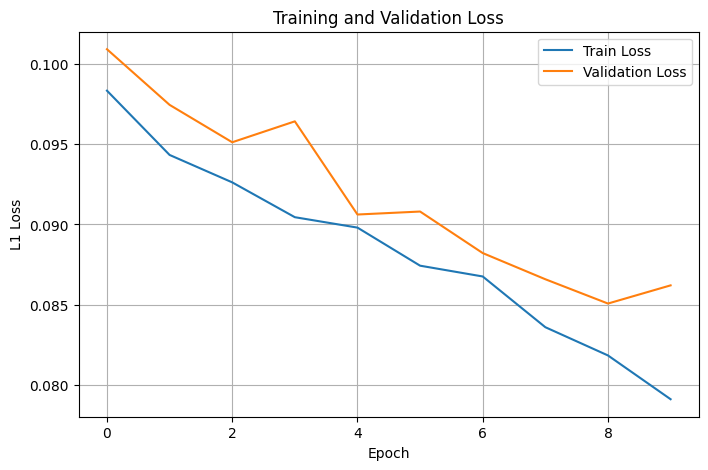

In [ ]:
train_losses, val_losses = train(model, train_loader, val_loader, epochs=10)
plot_loss(train_losses, val_losses)
torch.save(model.state_dict(), "unet_l1_final.pth")


In [ ]:
def compute_iou(preds, targets, threshold=0.5):
    preds = (preds > threshold).float()
    targets = (targets > threshold).float()

    intersection = (preds * targets).sum(dim=(1, 2, 3))
    union = preds.sum(dim=(1, 2, 3)) + targets.sum(dim=(1, 2, 3)) - intersection + 1e-6

    iou = intersection / union
    return iou.mean().item()


In [ ]:
def evaluate_iou(model, test_loader):
    model.eval()
    model.to(device)
    total_iou = 0.0
    count = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            iou = compute_iou(outputs, targets)
            total_iou += iou
            count += 1

    avg_iou = total_iou / count
    print(f"Average IoU on test set: {avg_iou:.4f}")
    return avg_iou

# Example usage
evaluate_iou(model, test_loader)


Average IoU on test set: 0.9426


0.9425719827413559

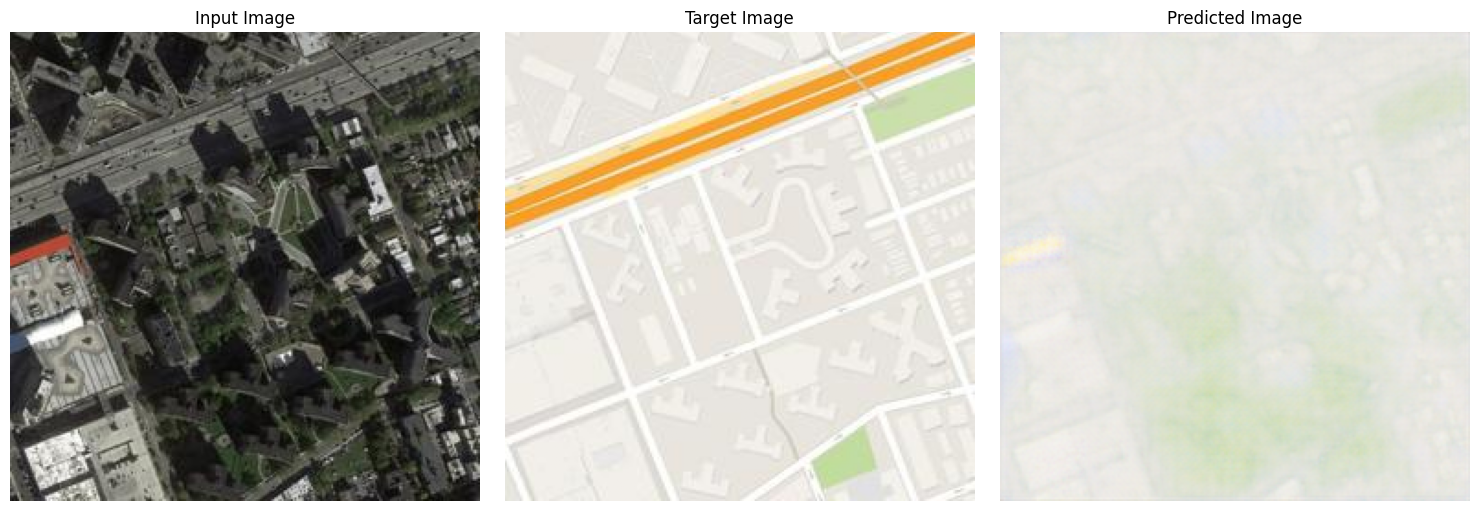

In [ ]:
import torch
import matplotlib.pyplot as plt
import random
import numpy as np

def denormalize(img):
    # Convert from [-1, 1] to [0, 1]
    return (img + 1) / 2.0

def show_generator_prediction(model, test_loader):
    model.eval()
    model.to(device)

    # Get a random batch
    inputs, targets = next(iter(test_loader))
    rand_idx = random.randint(0, inputs.size(0) - 1)

    inputs = inputs.to(device)
    with torch.no_grad():
        preds = model(inputs)

    # Get CPU tensors
    input_img = inputs[rand_idx].cpu().permute(1, 2, 0).numpy()
    target_img = targets[rand_idx].cpu().permute(1, 2, 0).numpy()
    pred_img = preds[rand_idx].cpu().permute(1, 2, 0).numpy()

    # De-normalize if using Tanh activation
    input_img = denormalize(input_img)
    target_img = denormalize(target_img)
    pred_img = denormalize(pred_img)

    # Clip for safe display
    input_img = np.clip(input_img, 0, 1)
    target_img = np.clip(target_img, 0, 1)
    pred_img = np.clip(pred_img, 0, 1)

    # Plot images
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(input_img)
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(target_img)
    plt.title("Target Image")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_img)
    plt.title("Predicted Image")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Example usage after training:
show_generator_prediction(model, test_loader)


Epoch 1: 100%|██████████| 28/28 [00:46<00:00,  1.65s/it]


[1/20] Train Loss: 0.0749 | Val Loss: 0.0796


Epoch 2: 100%|██████████| 28/28 [00:45<00:00,  1.64s/it]


[2/20] Train Loss: 0.0756 | Val Loss: 0.0823


Epoch 3: 100%|██████████| 28/28 [00:45<00:00,  1.63s/it]


[3/20] Train Loss: 0.0731 | Val Loss: 0.0788


Epoch 4: 100%|██████████| 28/28 [00:45<00:00,  1.64s/it]


[4/20] Train Loss: 0.0713 | Val Loss: 0.0864


Epoch 5: 100%|██████████| 28/28 [00:45<00:00,  1.63s/it]


[5/20] Train Loss: 0.0701 | Val Loss: 0.0761


Epoch 6: 100%|██████████| 28/28 [00:46<00:00,  1.66s/it]


[6/20] Train Loss: 0.0693 | Val Loss: 0.0803


Epoch 7: 100%|██████████| 28/28 [00:47<00:00,  1.69s/it]


[7/20] Train Loss: 0.0714 | Val Loss: 0.0791


Epoch 8: 100%|██████████| 28/28 [00:46<00:00,  1.65s/it]


[8/20] Train Loss: 0.0700 | Val Loss: 0.0845


Epoch 9: 100%|██████████| 28/28 [00:46<00:00,  1.67s/it]


[9/20] Train Loss: 0.0710 | Val Loss: 0.0726


Epoch 10: 100%|██████████| 28/28 [00:45<00:00,  1.64s/it]


[10/20] Train Loss: 0.0685 | Val Loss: 0.0918


Epoch 11: 100%|██████████| 28/28 [00:45<00:00,  1.62s/it]


[11/20] Train Loss: 0.0744 | Val Loss: 0.0808


Epoch 12: 100%|██████████| 28/28 [00:45<00:00,  1.64s/it]


[12/20] Train Loss: 0.0714 | Val Loss: 0.0732


Epoch 13: 100%|██████████| 28/28 [00:45<00:00,  1.63s/it]


[13/20] Train Loss: 0.0699 | Val Loss: 0.0724


Epoch 14: 100%|██████████| 28/28 [00:45<00:00,  1.62s/it]


[14/20] Train Loss: 0.0693 | Val Loss: 0.0813


Epoch 15: 100%|██████████| 28/28 [00:45<00:00,  1.64s/it]


[15/20] Train Loss: 0.0687 | Val Loss: 0.0731


Epoch 16: 100%|██████████| 28/28 [00:45<00:00,  1.63s/it]


[16/20] Train Loss: 0.0662 | Val Loss: 0.0706


Epoch 17: 100%|██████████| 28/28 [00:45<00:00,  1.63s/it]


[17/20] Train Loss: 0.0661 | Val Loss: 0.0706


Epoch 18: 100%|██████████| 28/28 [00:45<00:00,  1.64s/it]


[18/20] Train Loss: 0.0660 | Val Loss: 0.0715


Epoch 19: 100%|██████████| 28/28 [00:45<00:00,  1.63s/it]


[19/20] Train Loss: 0.0659 | Val Loss: 0.0732


Epoch 20: 100%|██████████| 28/28 [00:45<00:00,  1.63s/it]


[20/20] Train Loss: 0.0661 | Val Loss: 0.0709


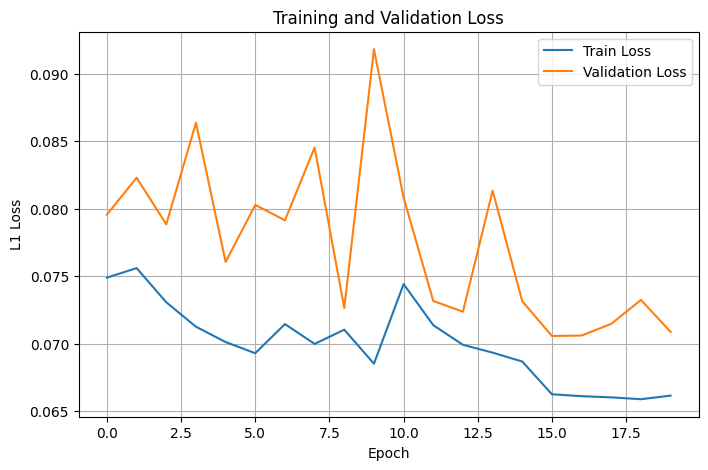

In [ ]:
train_losses, val_losses = train(model, train_loader, val_loader, epochs=20)
plot_loss(train_losses, val_losses)
torch.save(model.state_dict(), "unet_l1_20_epochs.pth")


Average IoU on test set: 0.9619


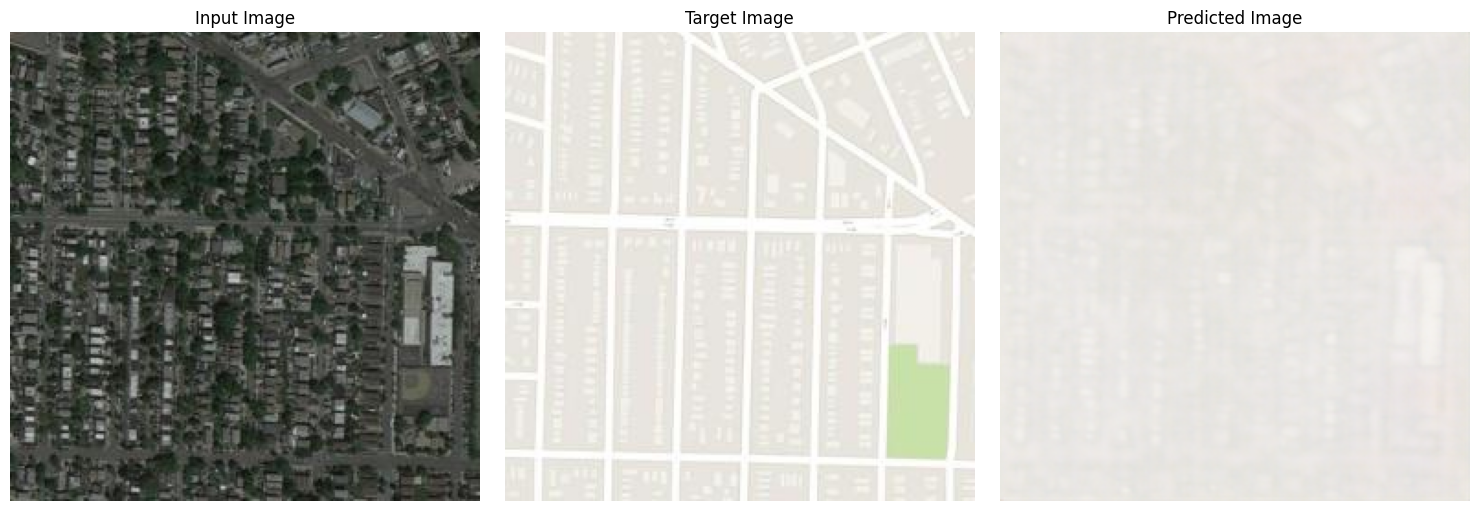

In [ ]:
evaluate_iou(model, test_loader)
show_generator_prediction(model, test_loader)

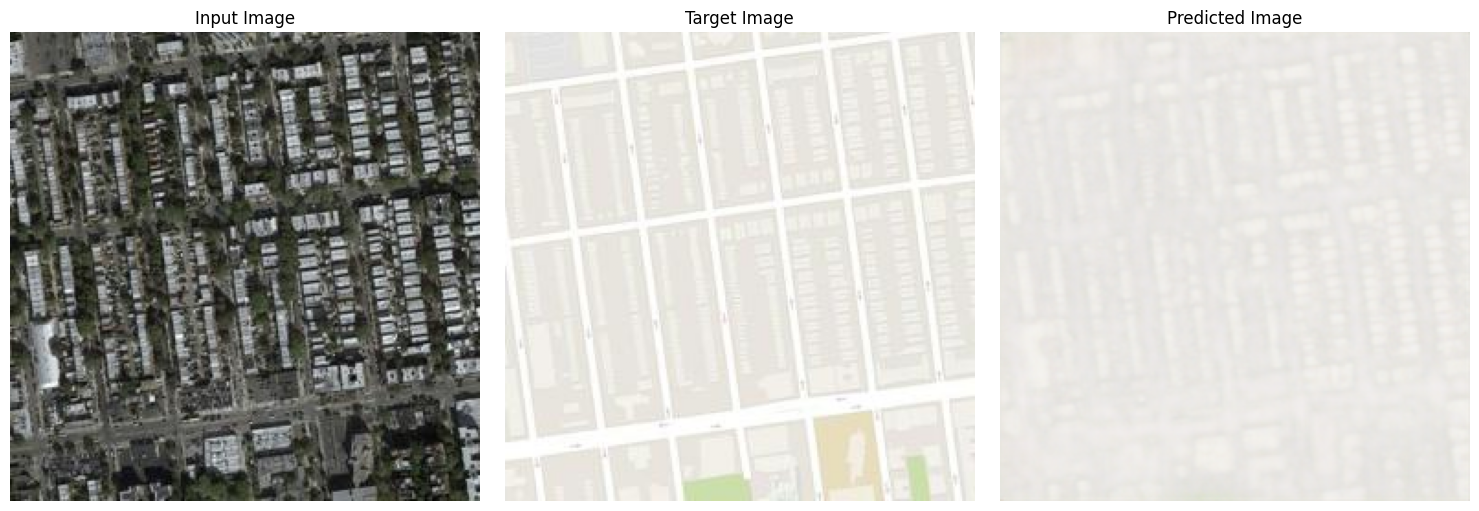

In [ ]:
show_generator_prediction(model, test_loader)

In [ ]:
class UNet(nn.Module):
    def __init__(self, img_channels=3):
        super(UNet, self).__init__()

        def conv_block(in_channels, out_channels, dropout=0.0):
            layers = [
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            ]
            if dropout > 0:
                layers.insert(2, nn.Dropout(dropout))
            return nn.Sequential(*layers)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Contracting path
        self.c1 = conv_block(img_channels, 16, dropout=0.1)
        self.c2 = conv_block(16, 32, dropout=0.1)
        self.c3 = conv_block(32, 64, dropout=0.2)
        self.c4 = conv_block(64, 128, dropout=0.2)
        self.c5 = conv_block(128, 256, dropout=0.3)

        # Expansive path
        self.up6 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.c6 = conv_block(256, 128, dropout=0.2)

        self.up7 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.c7 = conv_block(128, 64, dropout=0.2)

        self.up8 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.c8 = conv_block(64, 32, dropout=0.1)

        self.up9 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.c9 = conv_block(32, 16, dropout=0.1)

        self.out = nn.Conv2d(16, 3, kernel_size=1)

    def forward(self, x):
        # Encoder
        c1 = self.c1(x)
        p1 = self.pool(c1)

        c2 = self.c2(p1)
        p2 = self.pool(c2)

        c3 = self.c3(p2)
        p3 = self.pool(c3)

        c4 = self.c4(p3)
        p4 = self.pool(c4)

        c5 = self.c5(p4)

        # Decoder
        u6 = self.up6(c5)
        u6 = torch.cat([u6, c4], dim=1)
        c6 = self.c6(u6)

        u7 = self.up7(c6)
        u7 = torch.cat([u7, c3], dim=1)
        c7 = self.c7(u7)

        u8 = self.up8(c7)
        u8 = torch.cat([u8, c2], dim=1)
        c8 = self.c8(u8)

        u9 = self.up9(c8)
        u9 = torch.cat([u9, c1], dim=1)
        c9 = self.c9(u9)

        out = self.out(c9)
        return torch.sigmoid(out)

model = UNet()
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

def show_unet_prediction(model, test_loader):
    model.eval()
    model.to(device)

    # Fetch one random batch
    inputs, targets = next(iter(test_loader))
    rand_idx = random.randint(0, inputs.size(0) - 1)

    inputs, targets = inputs.to(device), targets.to(device)
    with torch.no_grad():
        preds = model(inputs)

    # Extract one sample
    input_img = inputs[rand_idx].cpu().permute(1, 2, 0).numpy()
    target_img = targets[rand_idx].cpu().permute(1, 2, 0).numpy()
    pred_img = preds[rand_idx].cpu().permute(1, 2, 0).numpy()

    # Clip predictions and inputs to [0, 1] for imshow
    input_img = np.clip(input_img, 0, 1)
    target_img = np.clip(target_img, 0, 1)
    pred_img = np.clip(pred_img, 0, 1)

    # Plot input, ground truth, prediction
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(input_img)
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(target_img)
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_img)
    plt.title("Predicted Image")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


Epoch 1: 100%|██████████| 28/28 [00:25<00:00,  1.10it/s]


[1/10] Train Loss: 0.2015 | Val Loss: 0.1559


Epoch 2: 100%|██████████| 28/28 [00:25<00:00,  1.09it/s]


[2/10] Train Loss: 0.1207 | Val Loss: 0.1092


Epoch 3: 100%|██████████| 28/28 [00:25<00:00,  1.10it/s]


[3/10] Train Loss: 0.1017 | Val Loss: 0.1053


Epoch 4: 100%|██████████| 28/28 [00:25<00:00,  1.11it/s]


[4/10] Train Loss: 0.0997 | Val Loss: 0.1039


Epoch 5: 100%|██████████| 28/28 [00:25<00:00,  1.09it/s]


[5/10] Train Loss: 0.0983 | Val Loss: 0.1029


Epoch 6: 100%|██████████| 28/28 [00:25<00:00,  1.09it/s]


[6/10] Train Loss: 0.0971 | Val Loss: 0.1021


Epoch 7: 100%|██████████| 28/28 [00:25<00:00,  1.09it/s]


[7/10] Train Loss: 0.0957 | Val Loss: 0.1003


Epoch 8: 100%|██████████| 28/28 [00:25<00:00,  1.11it/s]


[8/10] Train Loss: 0.0945 | Val Loss: 0.1001


Epoch 9: 100%|██████████| 28/28 [00:25<00:00,  1.09it/s]


[9/10] Train Loss: 0.0931 | Val Loss: 0.0977


Epoch 10: 100%|██████████| 28/28 [00:25<00:00,  1.10it/s]


[10/10] Train Loss: 0.0907 | Val Loss: 0.0927


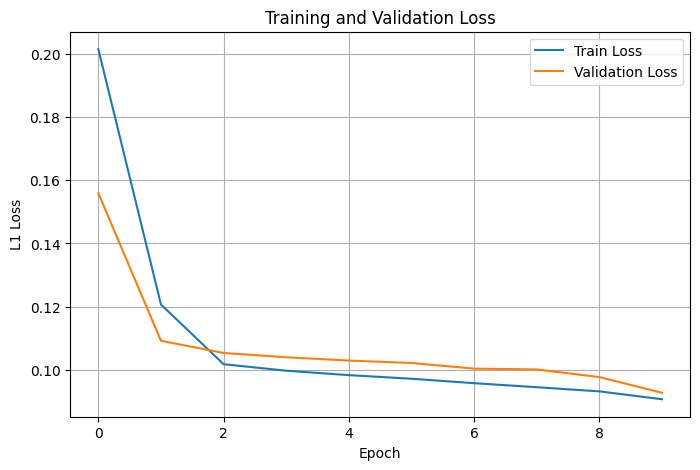

Average IoU on test set: 0.9340


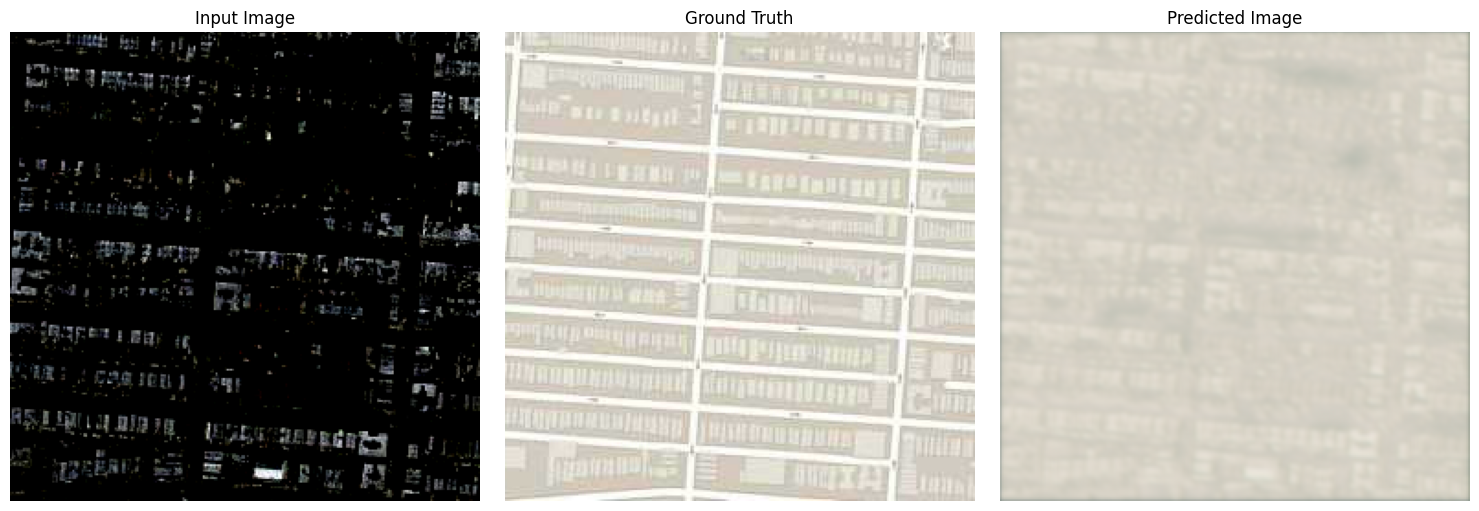

In [ ]:
train_losses, val_losses = train(model, train_loader, val_loader, epochs=10)
plot_loss(train_losses, val_losses)
torch.save(model.state_dict(), "unet_l1_UNet.pth")
evaluate_iou(model, test_loader)
show_unet_prediction(model, test_loader)

Epoch 1: 100%|██████████| 28/28 [00:26<00:00,  1.08it/s]


[1/30] Train Loss: 0.0867 | Val Loss: 0.0823


Epoch 2: 100%|██████████| 28/28 [00:26<00:00,  1.07it/s]


[2/30] Train Loss: 0.0837 | Val Loss: 0.0802


Epoch 3: 100%|██████████| 28/28 [00:25<00:00,  1.09it/s]


[3/30] Train Loss: 0.0805 | Val Loss: 0.0785


Epoch 4: 100%|██████████| 28/28 [00:26<00:00,  1.06it/s]


[4/30] Train Loss: 0.0808 | Val Loss: 0.0808


Epoch 5: 100%|██████████| 28/28 [00:26<00:00,  1.08it/s]


[5/30] Train Loss: 0.0788 | Val Loss: 0.0778


Epoch 6: 100%|██████████| 28/28 [00:26<00:00,  1.07it/s]


[6/30] Train Loss: 0.0785 | Val Loss: 0.0768


Epoch 7: 100%|██████████| 28/28 [00:26<00:00,  1.07it/s]


[7/30] Train Loss: 0.0770 | Val Loss: 0.0762


Epoch 8: 100%|██████████| 28/28 [00:26<00:00,  1.07it/s]


[8/30] Train Loss: 0.0755 | Val Loss: 0.0779


Epoch 9: 100%|██████████| 28/28 [00:25<00:00,  1.08it/s]


[9/30] Train Loss: 0.0747 | Val Loss: 0.0765


Epoch 10: 100%|██████████| 28/28 [00:25<00:00,  1.09it/s]


[10/30] Train Loss: 0.0732 | Val Loss: 0.0750


Epoch 11: 100%|██████████| 28/28 [00:25<00:00,  1.10it/s]


[11/30] Train Loss: 0.0724 | Val Loss: 0.0760


Epoch 12: 100%|██████████| 28/28 [00:25<00:00,  1.09it/s]


[12/30] Train Loss: 0.0727 | Val Loss: 0.0747


Epoch 13: 100%|██████████| 28/28 [00:25<00:00,  1.10it/s]


[13/30] Train Loss: 0.0720 | Val Loss: 0.0759


Epoch 14: 100%|██████████| 28/28 [00:25<00:00,  1.09it/s]


[14/30] Train Loss: 0.0710 | Val Loss: 0.0735


Epoch 15: 100%|██████████| 28/28 [00:25<00:00,  1.10it/s]


[15/30] Train Loss: 0.0704 | Val Loss: 0.0739


Epoch 16: 100%|██████████| 28/28 [00:25<00:00,  1.09it/s]


[16/30] Train Loss: 0.0697 | Val Loss: 0.0725


Epoch 17: 100%|██████████| 28/28 [00:25<00:00,  1.10it/s]


[17/30] Train Loss: 0.0691 | Val Loss: 0.0729


Epoch 18: 100%|██████████| 28/28 [00:25<00:00,  1.09it/s]


[18/30] Train Loss: 0.0688 | Val Loss: 0.0713


Epoch 19: 100%|██████████| 28/28 [00:25<00:00,  1.09it/s]


[19/30] Train Loss: 0.0686 | Val Loss: 0.0718


Epoch 20: 100%|██████████| 28/28 [00:25<00:00,  1.09it/s]


[20/30] Train Loss: 0.0683 | Val Loss: 0.0736


Epoch 21: 100%|██████████| 28/28 [00:25<00:00,  1.10it/s]


[21/30] Train Loss: 0.0688 | Val Loss: 0.0734


Epoch 22: 100%|██████████| 28/28 [00:25<00:00,  1.10it/s]


[22/30] Train Loss: 0.0687 | Val Loss: 0.0757


Epoch 23: 100%|██████████| 28/28 [00:25<00:00,  1.10it/s]


[23/30] Train Loss: 0.0683 | Val Loss: 0.0761


Epoch 24: 100%|██████████| 28/28 [00:25<00:00,  1.10it/s]


[24/30] Train Loss: 0.0694 | Val Loss: 0.0753


Epoch 25: 100%|██████████| 28/28 [00:25<00:00,  1.09it/s]


[25/30] Train Loss: 0.0682 | Val Loss: 0.0745


Epoch 26: 100%|██████████| 28/28 [00:25<00:00,  1.11it/s]


[26/30] Train Loss: 0.0677 | Val Loss: 0.0715


Epoch 27: 100%|██████████| 28/28 [00:25<00:00,  1.10it/s]


[27/30] Train Loss: 0.0673 | Val Loss: 0.0700


Epoch 28: 100%|██████████| 28/28 [00:25<00:00,  1.09it/s]


[28/30] Train Loss: 0.0663 | Val Loss: 0.0711


Epoch 29: 100%|██████████| 28/28 [00:25<00:00,  1.10it/s]


[29/30] Train Loss: 0.0661 | Val Loss: 0.0692


Epoch 30: 100%|██████████| 28/28 [00:25<00:00,  1.11it/s]


[30/30] Train Loss: 0.0662 | Val Loss: 0.0712


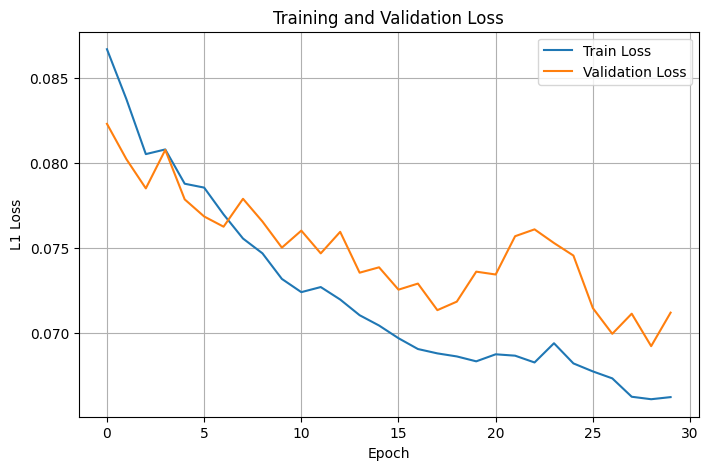

Average IoU on test set: 0.9580


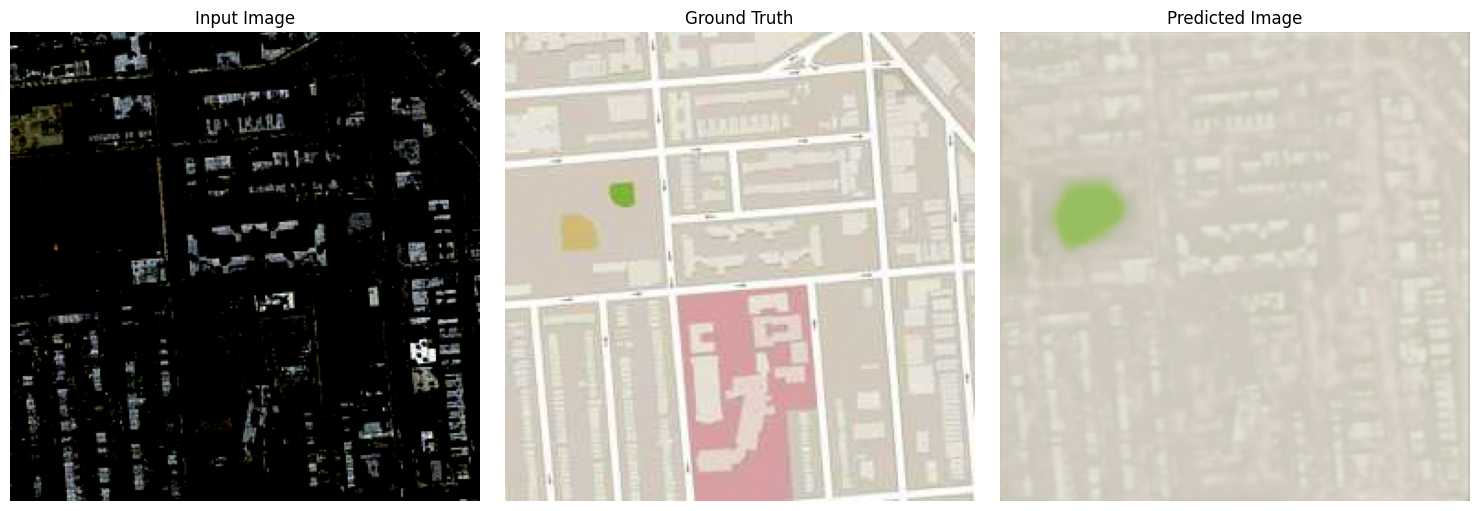

In [ ]:
train_losses, val_losses = train(model, train_loader, val_loader, epochs=30)
plot_loss(train_losses, val_losses)
torch.save(model.state_dict(), "unet_l1_UNet_30.pth")
evaluate_iou(model, test_loader)
show_unet_prediction(model, test_loader)

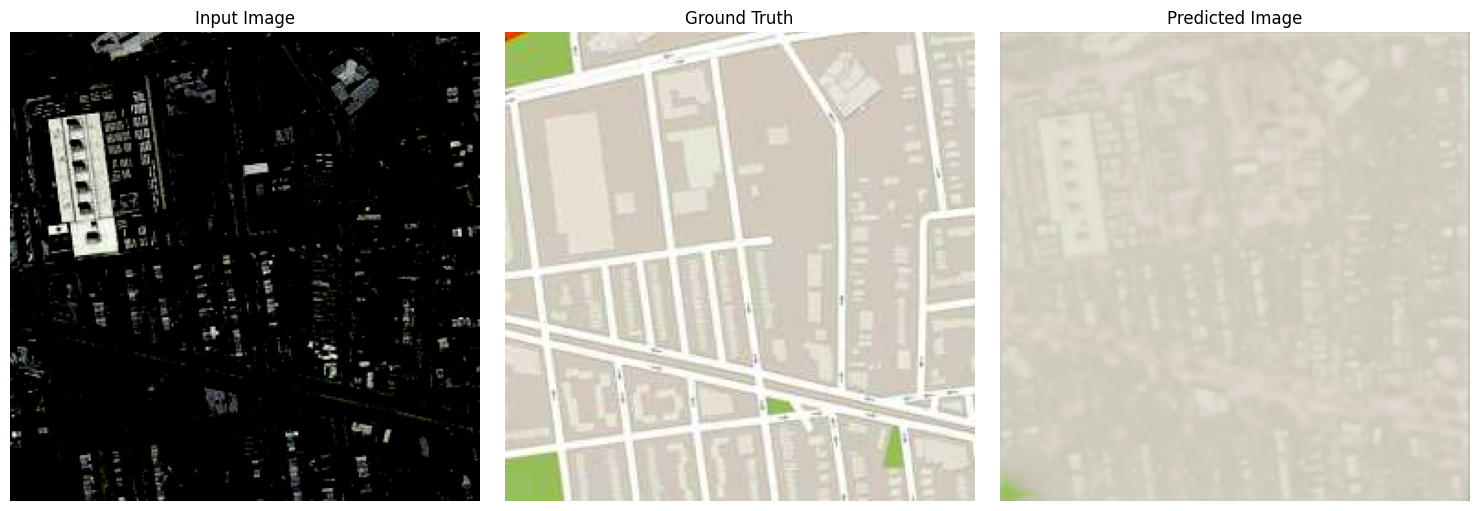

In [ ]:
show_unet_prediction(model, test_loader)

In [ ]:
import torch

def compute_iou(pred, target, threshold=0.5):
    """
    pred: model output (B, C, H, W) with values in [0, 1]
    target: ground truth (B, C, H, W)
    """
    pred_bin = (pred > threshold).int()
    target_bin = (target > threshold).int()

    intersection = (pred_bin & target_bin).sum(dim=(1,2,3))
    union = (pred_bin | target_bin).sum(dim=(1,2,3))

    iou = intersection.float() / (union.float() + 1e-8)
    return iou.mean().item()

def evaluate_iou(model, test_loader, device):
    model.eval()
    model.to(device)

    total_iou = 0.0
    num_batches = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            iou = compute_iou(outputs, targets)
            total_iou += iou
            num_batches += 1

    avg_iou = total_iou / num_batches
    print(f"Average IoU over test set: {avg_iou:.4f}")
    return avg_iou


In [ ]:
evaluate_iou(model, test_loader, device)

Average IoU over test set: 0.9580


0.9579763859510422

In [ ]:
def evaluate_l1_loss(generator, val_loader, device=None):
    """
    Computes the average L1 loss (MAE) on the validation set.

    Args:
        generator (nn.Module): Trained generator/model.
        val_loader (DataLoader): Validation DataLoader.
        device (torch.device, optional): Device to run on. Default uses CUDA if available.

    Returns:
        float: Average L1 loss.
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    generator = generator.to(device)
    generator.eval()

    criterion = nn.L1Loss().to(device)
    total_l1_loss = 0.0
    num_batches = 0

    with torch.no_grad():
        for input_images, target_images in val_loader:
            input_images = input_images.to(device)
            target_images = target_images.to(device)

            fake_images = generator(input_images)
            loss = criterion(fake_images, target_images)

            total_l1_loss += loss.item()
            num_batches += 1

    average_l1_loss = total_l1_loss / num_batches
    print(f"Average L1 loss for the validation set: {average_l1_loss:.4f}")
    return average_l1_loss


In [ ]:
evaluate_l1_loss(generator=model, val_loader=val_loader)

Average L1 loss for the validation set: 0.0712


0.07119680196046829